In [1]:
# install some libraries if not installed already
!pip install --upgrade scikit-image 
!pip install imgaug
!pip install pandas==0.23.4
!pip install pydicom
!pip install seaborn==0.9.0

    100% |████████████████████████████████| 25.3MB 3.1MB/s eta 0:00:01           | 4.4MB 57.5MB/s eta 0:00:0101     | 9.7MB 56.2MB/s eta 0:00:01             | 12.6MB 58.2MB/s eta 0:00:01��███            | 15.8MB 62.2MB/s eta 0:00:01
    100% |████████████████████████████████| 2.0MB 18.6MB/s ta 0:00:01
    100% |████████████████████████████████| 706kB 25.1MB/s ta 0:00:01
    100% |████████████████████████████████| 4.4MB 14.0MB/s ta 0:00:01
    100% |████████████████████████████████| 686kB 32.8MB/s ta 0:00:01
    100% |████████████████████████████████| 1.5MB 25.9MB/s ta 0:00:01
    100% |████████████████████████████████| 25.4MB 3.3MB/s eta 0:00:01                               | 624kB 59.1MB/s eta 0:00:01% |█████▏                          | 4.1MB 58.0MB/s eta 0:00:01██▍                       | 6.7MB 57.8MB/s eta 0:00:01��████████████                   | 10.3MB 51.8MB/s eta 0:00:01�███▏            | 15.2MB 54.5MB/s eta 0:00:01     | 18.1MB 60.5MB/s eta 0:00:01�████████▉     | 21.4MB 64.7M

[

    82% |██�

    100% |████████████████████████████████| 7.0MB 10.1MB/s 


    100% |████████████████████████████████| 215kB 38.4MB/s ta 0:00:01


In [2]:
# import some libraries we will use
import os, sys, glob, csv, random
import pydicom

import matplotlib.pyplot as plt
import numpy as np

from skimage import io

import seaborn as sns
import pandas as pd

In [3]:
# MNIST handwritten digits

In [4]:
# get the dataset if you don't have it already or on Colab - 1
!git clone https://github.com/myleott/mnist_png.git

Cloning into 'mnist_png'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), done.
Checking connectivity... done.


In [5]:
# get the dataset if you don't have it already or on Colab - 2
os.chdir('mnist_png')

In [6]:
# get the dataset if you don't have it already or on Colab - 3
!tar -xzf mnist_png.tar.gz
!ls

LICENSE  README.md  convert_mnist_to_png.py  mnist_png	mnist_png.tar.gz


In [7]:
mnist_base_dir_tr = 'mnist_png' # or point to appropriate directory if you're on Biowulf and already have the data

In [8]:
# load all images in the training set
mnist_digits = dict.fromkeys(range(10))
for num in range(10):
    mnist_digits[num] = glob.glob(os.path.join(mnist_base_dir_tr, 'training', str(num), '*.png'))

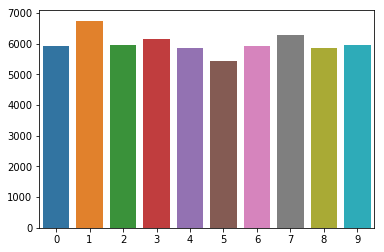

In [9]:
# visualize the number of class instances
sns.barplot(x=[num for num in range(10)], y=[len(mnist_digits[num]) for num in mnist_digits])

In [10]:
# Exercise #1: Get the total number of instances (digits 0-9) in the training set

In [11]:
# Exercise #2: Do the same (visualize number of class instances, get total number of instances) for the testing set

In [12]:
# Get the mean and std of the 1000 sample images of each digits in the training set
digits_sample_1000 = np.empty((10*1000,28*28))
idx = 0
for num in range(10):
    ridx = random.sample(range(len(mnist_digits[num])), 1000)
    for i in range(1000):
        digits_sample_1000[idx] = io.imread(mnist_digits[num][ridx[i]]).flatten()
        idx += 1

In [13]:
print('mean:', round(np.mean(digits_sample_1000), 2), 'std:', round(np.std(digits_sample_1000), 2))

mean: 33.62 std: 78.87


In [14]:
# normalize the data to have zero mean and 1 std
digits_sample_1000_norm = (digits_sample_1000 - np.mean(digits_sample_1000)) / np.std(digits_sample_1000)

In [15]:
print('mean:', round(np.mean(digits_sample_1000_norm), 2), 'std:', round(np.std(digits_sample_1000_norm), 2))

mean: 0.0 std: 1.0


In [16]:
# chest x-ray

In [17]:
# Download and unzip pneumonia detection data if you're on Colab or don't have it already on Biowulf - 1
ROOT_DIR = '../pn_chest_xray'
if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [18]:
# Download and unzip pneumonia detection data if you're on Colab or don't have it already on Biowulf - 2
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1ertt7A696f8HC0qk-yqmSoTZKCsp2XWU' -O stage_1_train_images.zip

will be placed in the single file you specified.

--2019-03-01 18:12:10--  https://docs.google.com/uc?export=download&id=1ertt7A696f8HC0qk-yqmSoTZKCsp2XWU
Resolving docs.google.com (docs.google.com)... 172.217.6.78, 2607:f8b0:4005:80a::200e
Connecting to docs.google.com (docs.google.com)|172.217.6.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘stage_1_train_images.zip’

stage_1_train_image     [ <=>                ]   3.18K  --.-KB/s    in 0.001s  

2019-03-01 18:12:10 (5.46 MB/s) - ‘stage_1_train_images.zip’ saved [3259]

Loading robots.txt; please ignore errors.
--2019-03-01 18:12:10--  https://docs.google.com/robots.txt
Reusing existing connection to docs.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘stage_1_train_images.zip’

stage_1_train_image     [ <=>                ]     567  --.-KB/s    in 0s      

2019-03-01 18:12:10 (59.3 MB/s) - ‘stage_1_train_im

In [19]:
# Download and unzip pneumonia detection data if you're on Colab or don't have it already on Biowulf - 3
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1ppgqzDVa9hQYbxgjV_k7AUUOKTw7ca9Q' -O stage_1_test_images.zip

will be placed in the single file you specified.

--2019-03-01 18:13:46--  https://docs.google.com/uc?export=download&id=1ppgqzDVa9hQYbxgjV_k7AUUOKTw7ca9Q
Resolving docs.google.com (docs.google.com)... 172.217.6.78, 2607:f8b0:4005:80a::200e
Connecting to docs.google.com (docs.google.com)|172.217.6.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘stage_1_test_images.zip’

stage_1_test_images     [ <=>                ]   3.18K  --.-KB/s    in 0s      

2019-03-01 18:13:46 (60.4 MB/s) - ‘stage_1_test_images.zip’ saved [3258]

Loading robots.txt; please ignore errors.
--2019-03-01 18:13:46--  https://docs.google.com/robots.txt
Reusing existing connection to docs.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘stage_1_test_images.zip’

stage_1_test_images     [ <=>                ]     567  --.-KB/s    in 0s      

2019-03-01 18:13:46 (20.2 MB/s) - ‘stage_1_test_images

In [20]:
# Download and unzip pneumonia detection data if you're on Colab or don't have it already on Biowulf - 4
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1yI8jJw9DGMeZeMgHaoZBUeuebt11qe0v' -O stage_1_train_labels.csv.zip

will be placed in the single file you specified.

--2019-03-01 18:13:52--  https://docs.google.com/uc?export=download&id=1yI8jJw9DGMeZeMgHaoZBUeuebt11qe0v
Resolving docs.google.com (docs.google.com)... 172.217.6.78, 2607:f8b0:4005:80a::200e
Connecting to docs.google.com (docs.google.com)|172.217.6.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o8v1e6gqilkndmmslsf2p1e1slbabpmh/1551463200000/04085785759417533061/*/1yI8jJw9DGMeZeMgHaoZBUeuebt11qe0v?e=download [following]
--2019-03-01 18:13:53--  https://doc-00-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o8v1e6gqilkndmmslsf2p1e1slbabpmh/1551463200000/04085785759417533061/*/1yI8jJw9DGMeZeMgHaoZBUeuebt11qe0v?e=download
Resolving doc-00-ao-docs.googleusercontent.com (doc-00-ao-docs.googleusercontent.com)... 172.217.6.65, 2607:f8b0:4005:80a::2001
Connecting to doc-00-ao-docs

In [21]:
# Download and unzip pneumonia detection data if you're on Colab or don't have it already on Biowulf - 5
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1lpa5bsCKOgesx1zP7h5UIDwN4FzvjooD' -O stage_1_detailed_class_info.csv.zip

will be placed in the single file you specified.

--2019-03-01 18:13:54--  https://docs.google.com/uc?export=download&id=1lpa5bsCKOgesx1zP7h5UIDwN4FzvjooD
Resolving docs.google.com (docs.google.com)... 172.217.6.78, 2607:f8b0:4005:80a::200e
Connecting to docs.google.com (docs.google.com)|172.217.6.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vj53k60edhof5m61nr7ccbfb1koh6i7o/1551463200000/04085785759417533061/*/1lpa5bsCKOgesx1zP7h5UIDwN4FzvjooD?e=download [following]
--2019-03-01 18:13:55--  https://doc-14-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vj53k60edhof5m61nr7ccbfb1koh6i7o/1551463200000/04085785759417533061/*/1lpa5bsCKOgesx1zP7h5UIDwN4FzvjooD?e=download
Resolving doc-14-ao-docs.googleusercontent.com (doc-14-ao-docs.googleusercontent.com)... 172.217.6.65, 2607:f8b0:4005:80a::2001
Connecting to doc-14-ao-docs

In [22]:
# Download and unzip pneumonia detection data if you're on Colab or don't have it already on Biowulf - 6
# unzipping takes a few minutes
!unzip -q -o stage_1_test_images.zip -d stage_1_test_images
!unzip -q -o stage_1_train_images.zip -d stage_1_train_images
!unzip -q -o stage_1_train_labels.csv.zip
!unzip -q -o stage_1_detailed_class_info.csv.zip

warning [stage_1_test_images.zip]:  414659 extra bytes at beginning or within zipfile
  (attempting to process anyway)
[stage_1_train_images.zip]
error: End-of-centdir-64 signature not where expected (prepended bytes?)
  (attempting to process anyway)
warning [stage_1_train_images.zip]:  414666 extra bytes at beginning or within zipfile
  (attempting to process anyway)


In [23]:
# Download and unzip pneumonia detection data if you're on Colab or don't have it already on Biowulf - 7
# fix some permission issues
!chmod 644 stage_1_detailed_class_info.csv
!chmod 644 stage_1_train_labels.csv

In [24]:
# Helper function to load the chest x-ray pneumonia dataset
def load_cxray_list(ROOT_DIR, stage_num, test_only_part):
  train_dicom_dir = os.path.join(ROOT_DIR, 'stage_' + stage_num + '_train_images')
  test_dicom_dir = os.path.join(ROOT_DIR, 'stage_' + stage_num + '_test_images')
  bbox_path = os.path.join(ROOT_DIR, 'stage_' + stage_num + '_train_labels.csv')

  # make DataFrame with images
  det_class_df = pd.read_csv(os.path.join(ROOT_DIR, 'stage_' + stage_num + '_detailed_class_info.csv'))
  bbox_df = pd.read_csv(os.path.join(ROOT_DIR, 'stage_' + stage_num + '_train_labels.csv'))
  comb_bbox_df = pd.concat([bbox_df, 
                            det_class_df.drop('patientId',1)], 1)
 
  image_df = pd.DataFrame({'path': glob.glob(os.path.join(train_dicom_dir, '*.dcm'))})
  image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])

  if test_only_part:
    det_class_df = det_class_df.iloc[:1000]
    bbox_df = bbox_df.iloc[:1000]
    comb_bbox_df = comb_bbox_df.iloc[:1000]

    image_df = (comb_bbox_df.merge(image_df))[['path', 'patientId']]
 
  print(image_df.shape[0], 'images found')
  img_pat_ids = set(image_df['patientId'].values.tolist())
  box_pat_ids = set(comb_bbox_df['patientId'].values.tolist())
  # check to make sure there is no funny business
  assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

  # get data statistics
  DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
  def get_tags(in_path):
      c_dicom = pydicom.read_file(in_path, stop_before_pixels=True)
      tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
           for c_tag in DCM_TAG_LIST}
      tag_dict['path'] = in_path
      return pd.Series(tag_dict)
  image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
  image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)

  # merge into one DataFrame
  image_full_df = pd.merge(image_df,
                           image_meta_df,
                           on='path')
  image_bbox_df = pd.merge(comb_bbox_df, 
                           image_full_df, 
                           on='patientId',
                          how='left') 

  # make (image_path, label) lists
  image_paths = []
  labels = []
  class_to_label = {'Normal': 0, 'Lung Opacity': 1, 'No Lung Opacity / Not Normal': 2}
  for idx, row in image_bbox_df.iterrows():
      image_paths.append(row['path'])
      labels.append(class_to_label[row['class']])


  # shuffle
  image_paths_sh = []
  labels_sh = []
  idxs = np.random.permutation(len(image_paths))
  for i in range(len(image_paths)):
      image_paths_sh.append(image_paths[idxs[i]])
      labels_sh.append(labels[idxs[i]])

  # split the data into train/val
  image_paths_train = image_paths_sh[:round(len(image_paths_sh)*0.8)]
  labels_train = labels_sh[:round(len(labels_sh)*0.8)]
  
  image_paths_val = image_paths_sh[int(round(len(image_paths_sh)*0.8)):]
  labels_val = labels_sh[int(round(len(labels_sh)*0.8)):]

  return image_paths_train, labels_train, image_paths_val, labels_val

In [25]:
image_paths_train, labels_train, image_paths_val, labels_val = load_cxray_list(ROOT_DIR, '1', False)

25684 images found


In [ ]:
# Exercise 3: Plot the number of instances for each class in the training set
# ('Normal': 0, 'Lung Opacity': 1, 'No Lung Opacity / Not Normal': 2)

In [ ]:
# Exercise 4: Plot the number of instances for each class in the validation set

In [ ]:
# Exercise 5: Get the mean and std for the images in the training set

In [ ]:
# Normalize the images, and print the mean and std for the images in the training set

In [ ]:
seaborn.__version__

In [ ]:
import seaborn